### Biblioteker

In [85]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks

%reload_ext autoreload
%autoreload 2
from src import *

### Laste inn og gjennomsnittsberegne spektrale kalibreringsbilder

In [86]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

PixelWidth = 1936
PixelHeight = 1216

# Construct paths to the .bip files for each dataset
H_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'H', '*.bip'))  # Eksponering 50 ms
He_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'HE', '*.bip'))  # Eksponering 30 ms
Hg_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'HG', '*.bip'))  # Eksponering 100 ms

# Construct paths relative to the notebook's directory
H_avg_img_path = os.path.join(notebook_dir, 'Data', 'Average', 'H_avg.txt')
He_avg_img_path = os.path.join(notebook_dir,'Data', 'Average', 'He_avg.txt')
Hg_avg_img_path = os.path.join(notebook_dir, 'Data', 'Average', 'Hg_avg.txt')

## Calculate average images for each dataset and save them as .txt files (this is done only once)
#utils.calculate_average_image(H_paths, H_avg_img_path, PixelWidth, PixelHeight)
#utils.calculate_average_image(He_paths, He_avg_img_path, PixelWidth, PixelHeight)
#utils.calculate_average_image(Hg_paths, Hg_avg_img_path, PixelWidth, PixelHeight)

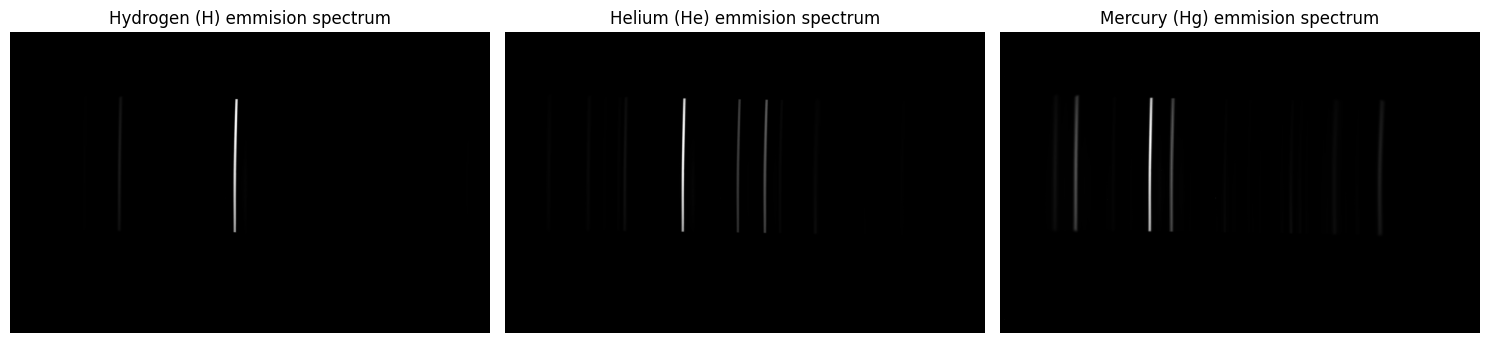

In [87]:
# Read average images
H_avg_img = np.loadtxt(H_avg_img_path, delimiter=',')
He_avg_img = np.loadtxt(He_avg_img_path, delimiter=',')
Hg_avg_img = np.loadtxt(Hg_avg_img_path, delimiter=',')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Display the images in the subplots
axes[0].imshow(H_avg_img, cmap='gray')
axes[0].set_title('Hydrogen (H) emmision spectrum')
axes[0].axis('off')  # Hide the axis

axes[1].imshow(He_avg_img, cmap='gray')
axes[1].set_title('Helium (He) emmision spectrum')
axes[1].axis('off')  # Hide the axis

axes[2].imshow(Hg_avg_img, cmap='gray')
axes[2].set_title('Mercury (Hg) emmision spectrum')
axes[2].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

### Identifisering av pikselverdier ved kjente bølgelengder

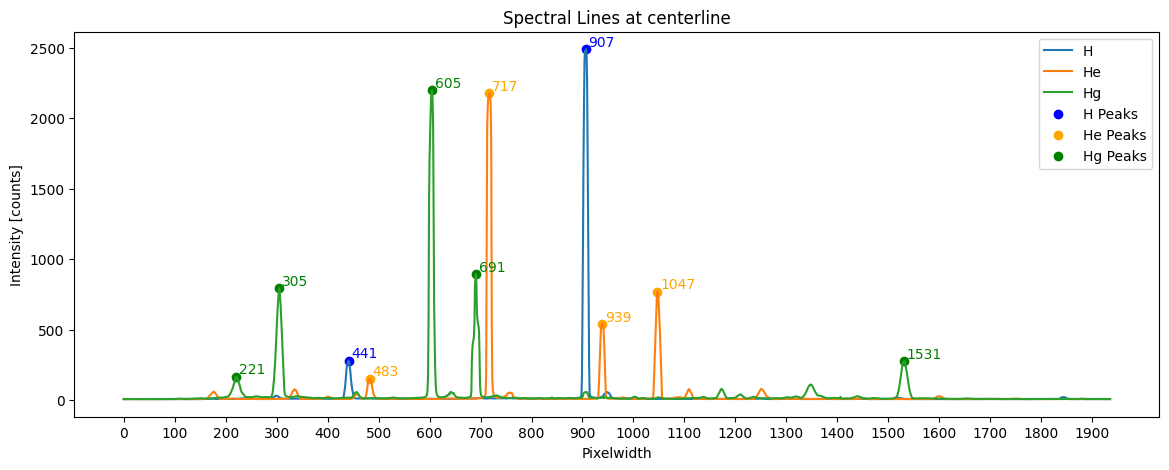

In [88]:
PixMid= PixelHeight//2

peak_threshold = 150  # Adjust this value as needed
prominence_threshold = 20  # Adjust this value as needed

# Find peaks for each spectrum above the threshold and with the specified prominence
peaks_H, _ = find_peaks(H_avg_img[PixMid, :], height=peak_threshold, prominence=prominence_threshold)
peaks_He, _ = find_peaks(He_avg_img[PixMid, :], height=peak_threshold, prominence=prominence_threshold)
peaks_Hg, _ = find_peaks(Hg_avg_img[PixMid, :], height=peak_threshold, prominence=prominence_threshold)

plt.figure(figsize=(14, 5))
plt.plot(H_avg_img[PixMid, :], label='H')
plt.plot(He_avg_img[PixMid, :], label='He')
plt.plot(Hg_avg_img[PixMid, :], label='Hg')

# Plot circles at the peak positions for H
plt.scatter(peaks_H, H_avg_img[PixMid, peaks_H], color='blue', label='H Peaks', marker='o')
for peak in peaks_H:
    plt.text(peak+5, H_avg_img[PixMid, peak], f'{peak}', color='blue', verticalalignment='bottom')

# Plot circles at the peak positions for He
plt.scatter(peaks_He, He_avg_img[PixMid, peaks_He], color='orange', label='He Peaks', marker='o')
for peak in peaks_He:
    plt.text(peak+5, He_avg_img[PixMid, peak], f'{peak}', color='orange', verticalalignment='bottom')

# Plot circles at the peak positions for Hg
plt.scatter(peaks_Hg, Hg_avg_img[PixMid, peaks_Hg], color='green', label='Hg Peaks', marker='o')
for peak in peaks_Hg:
    plt.text(peak+5, Hg_avg_img[PixMid, peak], f'{peak}', color='green', verticalalignment='bottom')

plt.legend()
plt.title('Spectral Lines at centerline')
plt.xlabel('Pixelwidth')
plt.ylabel('Intensity [counts]')
plt.xticks(np.arange(0, H_avg_img.shape[1], 100))
plt.show()

#### Estimere og lagre piksel til bølgelengde korrelasjon

   Degree  RMS Error         c_0       c_1       c_2           c_3
0       1   0.547629  324.771010  0.365232       NaN           NaN
1       2   0.311503  322.483154  0.374374 -0.000007           NaN
2       3   0.259813  324.666273  0.360635  0.000017 -1.283713e-08


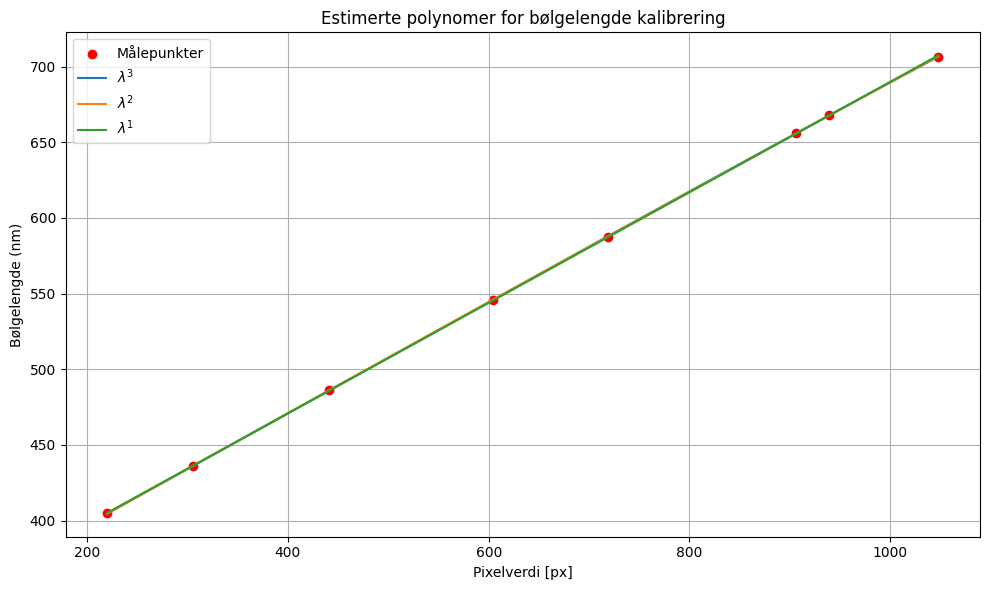

In [89]:
Spectral_lines = [404.7, 435.8, 486.1, 546.1, 587.5, 656.3, 667.8, 706.5] 
pixel_positions = [220, 305, 441, 604, 719, 906, 939, 1048] 

degrees = range(1, 4)  # Example: degrees from 1 to 5

# Perform polynomial fit for each degree and calculate RMS error
rms_errors = {}
polynomials = {}
coefficients_dict = {}

for degree in degrees:
    # Perform the calibration
    coefficients = np.polyfit(pixel_positions, Spectral_lines, degree)
    polynomial = np.poly1d(coefficients)
    polynomials[degree] = polynomial
    coefficients_dict[degree] = coefficients[::-1]
    
    # Predict the wavelengths using the polynomial
    predicted_wavelengths = polynomial(pixel_positions)
    
    # Calculate the RMS error
    rms_error = np.sqrt(np.mean((np.array(Spectral_lines) - np.array(predicted_wavelengths)) ** 2))
    rms_errors[degree] = rms_error

# Create a DataFrame to display the RMS errors and coefficients in a table
poly_df = pd.DataFrame(list(rms_errors.items()), columns=['Degree', 'RMS Error'])

# Add coefficients to the DataFrame
max_degree = max(degrees)
for i in range(max_degree + 1):
    poly_df[f'c_{i}'] = poly_df['Degree'].apply(lambda deg: coefficients_dict[deg][i] if i < len(coefficients_dict[deg]) else np.nan)

print(poly_df)

# Plot the original data points and polynomial fits
plt.figure(figsize=(10, 6))
plt.scatter(pixel_positions, Spectral_lines, color='red', label='Målepunkter')

# Plot the polynomial fits with different line thicknesses, thickest lines first
x_range = np.linspace(min(pixel_positions), max(pixel_positions), 500)
for degree in sorted(polynomials.keys(), reverse=True):
    polynomial = polynomials[degree]
    plt.plot(x_range, polynomial(x_range), label=rf'$\lambda^{degree}$')

plt.xlabel('Pixelverdi [px]')
plt.ylabel('Bølgelengde (nm)')
plt.title('Estimerte polynomer for bølgelengde kalibrering')
plt.legend()
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [90]:
degree = 2 # Degree of desired polynomial fit
output_file = os.path.join(notebook_dir, 'Data', 'Calibrated', 'calibrated_wavelengths.csv')

df = calibration.calibrate_wavelengths(PixelWidth, Spectral_lines, pixel_positions, degree, output_file)

### FWHM 

In [91]:
# Compute the FWHM for the first three orders
orders = [1, 2, 3]

theoretical_fwhm_values = [utils.theoretical_fwhm(order)*1e9 for order in orders] 

# Create a DataFrame to display the FWHM values
fwhm_df = pd.DataFrame(list(zip(orders, theoretical_fwhm_values)), columns=['Order', 'FWHM [nm]'])
print(fwhm_df)

   Order  FWHM [nm]
0      1   1.388889
1      2   0.694444
2      3   0.462963


   Peak Wavelength [nm]  FWHM [nm]
0            435.994258   4.809588
1            545.965869   3.290780
2            577.721355   4.008218


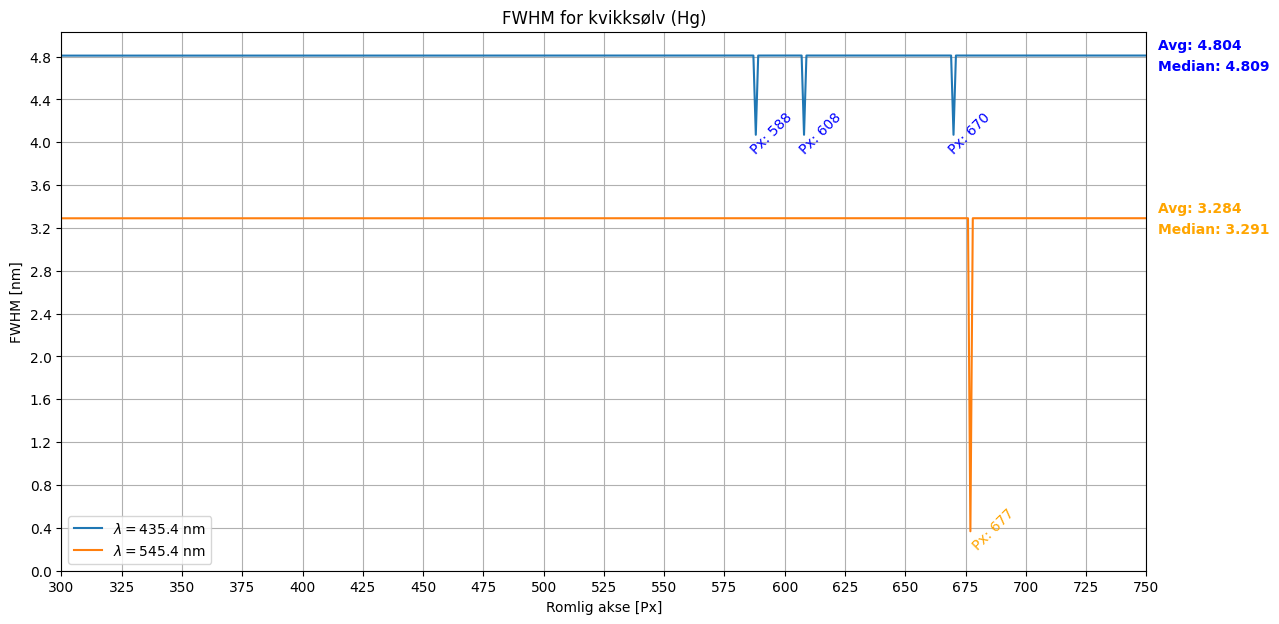

In [92]:
HgSpec, HgWave = calibration.pix_to_wavelength(Hg_avg_img)

# Create a DataFrame to display the peaks and their FWHM values
peaks_wavelengths, fwhm_values = utils.find_peaks_and_fwhm(HgWave, HgSpec[PixMid+50,:])
fwhm_df = pd.DataFrame(list(zip(peaks_wavelengths, fwhm_values)), columns=['Peak Wavelength [nm]', 'FWHM [nm]'])
print(fwhm_df)


# Initialize an empty list to store FWHM values
fwhm_arr1 = []
fwhm_arr2 = []
fwhm_arr3 = []

fwhm_range = np.arange(300, 751, 1) 

# Loop through the specified range of rows
for i in fwhm_range:
    peaks_wavelengths, fwhm_v = utils.find_peaks_and_fwhm(HgWave, HgSpec[i, :])
    fwhm_arr1.append(fwhm_v[0])
    fwhm_arr2.append(fwhm_v[1])
    fwhm_arr3.append(fwhm_v[2])
   
mean_fwhm1 = np.nanmean(fwhm_arr1)
mean_fwhm2 = np.nanmean(fwhm_arr2)

# Calculate median values
median_fwhm1 = np.nanmedian(fwhm_arr1)
median_fwhm2 = np.nanmedian(fwhm_arr2)

# Identify dips in the arrays
dips_arr1 = np.where(fwhm_arr1 < (median_fwhm1 - 0.3))[0]  # Adjust threshold as needed
dips_arr2 = np.where(fwhm_arr2 < (median_fwhm2 - 0.3))[0]  # Adjust threshold as needed

plt.figure(figsize=(14, 7))
plt.plot(fwhm_range, fwhm_arr1, label=r'$\lambda = 435.4$ nm')
plt.plot(fwhm_range, fwhm_arr2, label=r'$\lambda = 545.4$ nm')
plt.xlabel('Romlig akse [Px]')
plt.ylabel('FWHM [nm]')
plt.title('FWHM for kvikksølv (Hg)')
plt.xlim(fwhm_range[0], fwhm_range[-1])
plt.xticks(np.arange(fwhm_range[0], fwhm_range[-1] + 1, 25))
plt.yticks(np.arange(0, 5, 0.4))
plt.legend()
plt.grid(True)

# Add mean and median values as text annotations
plt.text(fwhm_range[-1] + 5, mean_fwhm1+0.1, f'Avg: {mean_fwhm1:.3f}', verticalalignment='center', color='blue', fontweight='bold')
plt.text(fwhm_range[-1] + 5, mean_fwhm2+0.1, f'Avg: {mean_fwhm2:.3f}', verticalalignment='center', color='orange', fontweight='bold')
plt.text(fwhm_range[-1] + 5, median_fwhm1-0.1, f'Median: {median_fwhm1:.3f}', verticalalignment='center', color='blue', fontweight='bold')
plt.text(fwhm_range[-1] + 5, median_fwhm2-0.1, f'Median: {median_fwhm2:.3f}', verticalalignment='center', color='orange', fontweight='bold')
# Add dips as text annotations
for dip in dips_arr1:
    plt.text(fwhm_range[dip]-3, fwhm_arr1[dip]-0.2, f'Px: {fwhm_range[dip]}', verticalalignment='bottom', color='blue', rotation=45)
for dip in dips_arr2:
    plt.text(fwhm_range[dip], fwhm_arr2[dip]-0.2, f'Px: {fwhm_range[dip]}', verticalalignment='bottom', color='orange', rotation=45)

plt.show()

### Test

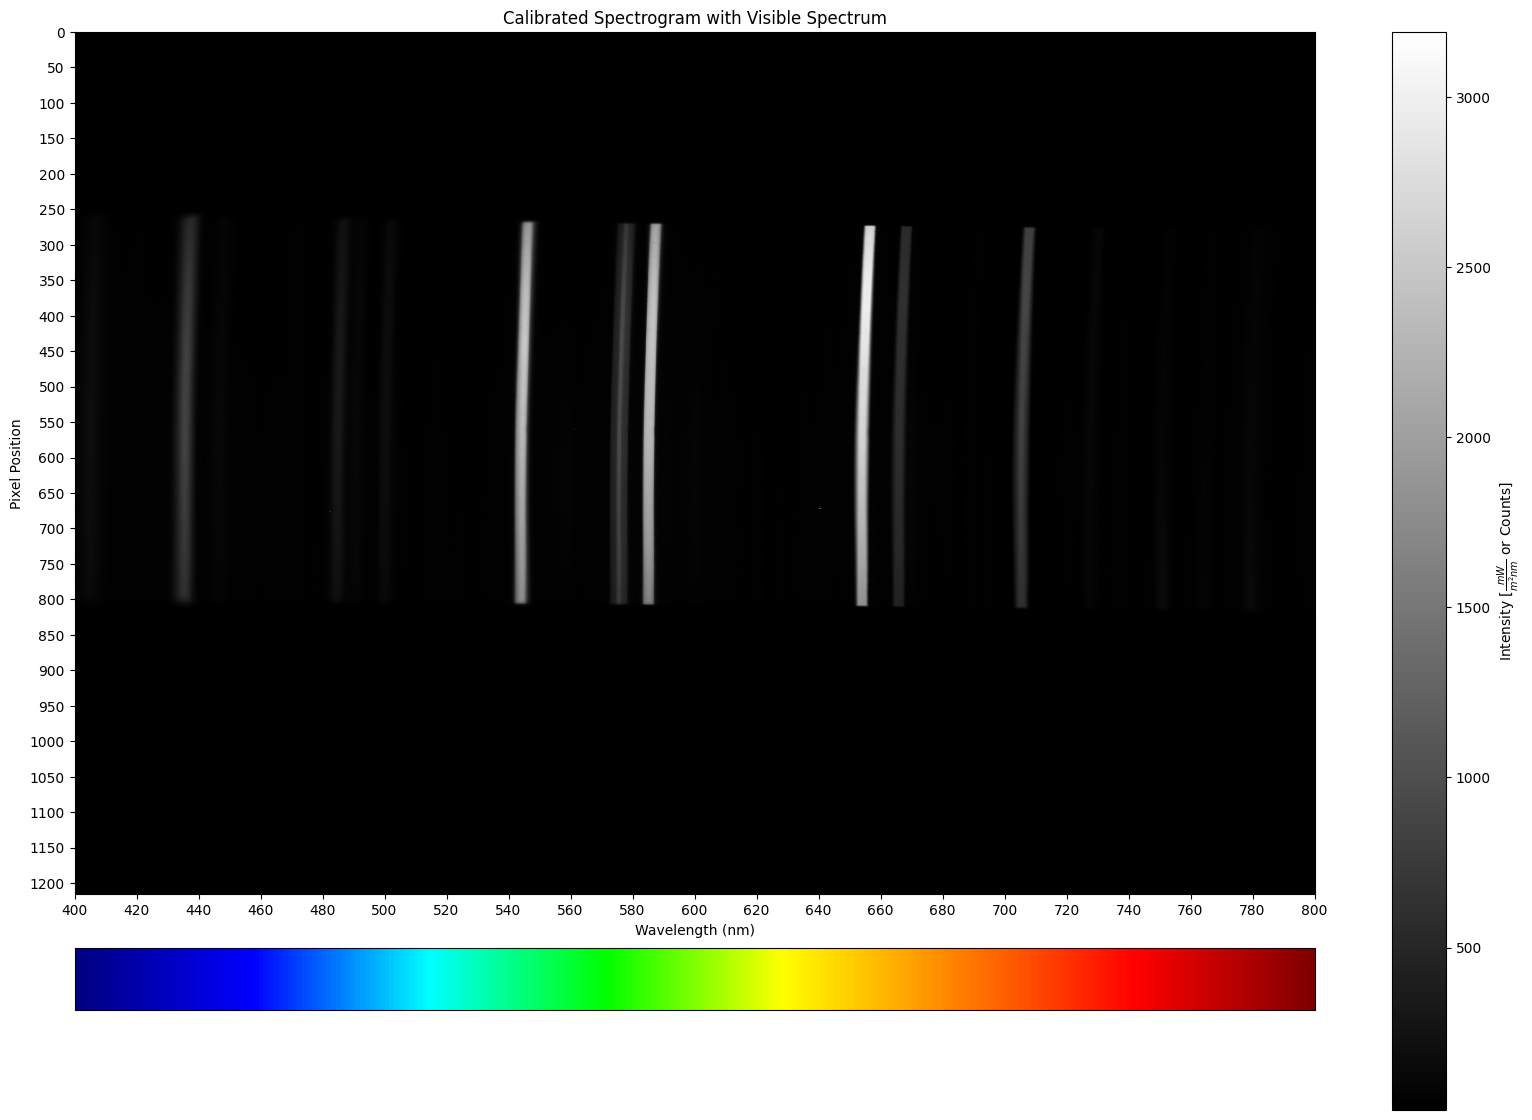

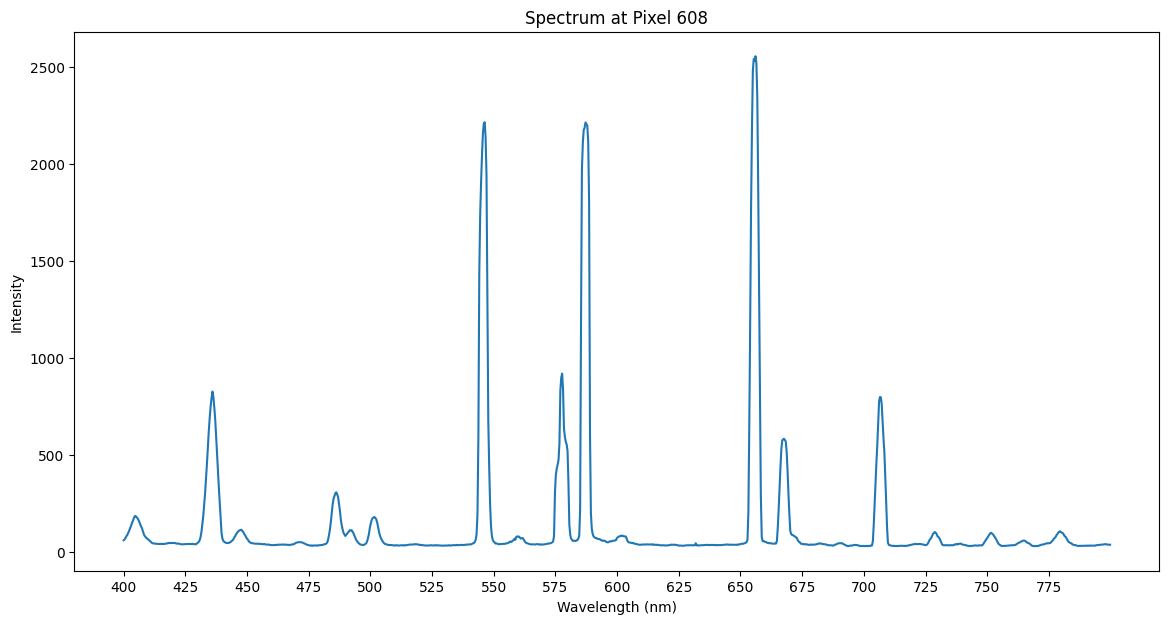

In [93]:
im =  H_avg_img + He_avg_img + Hg_avg_img ## Spectral_lines = [486.1, 656.3, 501.5, 587.5, 435.8, 546.1] # 2 Hydrogen (H), 2 Helium (He), 2 Mercury (Hg)
spec, wave = calibration.pix_to_wavelength(im)
visualization.plot_visible_spectrum_cmap(spec, wave)

plt.figure(figsize=(14, 7))
plt.plot(wave, spec[608,:])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Spectrum at Pixel 608')
plt.xticks(np.arange(400, 800, 25))
plt.show()